In [1]:
import logging
import os
import time
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

**Ingesting Clean Data into SQL for Aggregation**

In [2]:
logging.basicConfig(
    filename = "logs/sql_ingest_clean_tables.log",
    level = logging.DEBUG, 
    format = "%(asctime)s - %(levelname)s - %(message)s",
    filemode = "a")

engine = create_engine('sqlite:///clean_database.db')

def load_cleaned_data(): 
    start = time.time()
    for file in os.listdir('cleaned_data'): 
        if ".csv" in file: 
            df = pd.read_csv('cleaned_data/'+ file) 
            print(file, " file_shape: " ,df.shape)
            logging.info(f'Ingesting {file} in db')
            df.to_sql(file[:-4], engine, if_exists='replace', index = False) 
    end = time.time()
    total_time = (end - start)/60
    logging.info('--------------Ingestion Complete------------')
    logging.info(f'\nTotal Time Taken: {total_time} minutes')

if __name__ == '__main__':
    load_cleaned_data()

begin_inventory.csv  file_shape:  (8000, 11)
end_inventory.csv  file_shape:  (8000, 11)
purchases.csv  file_shape:  (32300, 21)
purchase_prices.csv  file_shape:  (12000, 11)
sales.csv  file_shape:  (95050, 16)
vendor_invoice.csv  file_shape:  (5200, 13)


**Data Aggregation**

As the data that we need for analysis is distributed in different tables, we need to create a summary table containing:
- purchase transactions made by vendors
- sales transaction data
- freight costs for each vendor
- actual product prices from vendors

In [3]:
freight_summary = pd.read_sql_query("""SELECT 
    VendorNumber, 
    SUM(Freight) as FreightCost 
FROM vendor_invoice 
GROUP BY VendorNumber""", engine)

freight_summary

,VendorNumber,FreightCost
0,Unknown,47419169.25
1,V001,26169425.04
2,V002,44331320.80
3,V003,87290155.62
4,V004,32354672.52
5,V005,82062622.29
6,V006,25642343.75
7,V007,56578208.96
8,V008,77346471.84
9,V009,46045368.00


In [4]:
# JOINING ON BRAND AS PURCHASE_PRICES IS THE PRODUCT DETAILS REFERENCE FILE AND PURCHASES ARE THE ACTUAL TRANSACTIONS

purchase_summary = pd.read_sql_query("""SELECT 
    p.VendorNumber, 
    p.VendorName_clean, 
    strftime('%m', p.PayDate_clean) AS PaymentMonth,
    p.Brand_clean, 
    p.Description, 
    ROUND(AVG(pp.Price),2) AS ActualPrice, 
    ROUND(AVG(p.PurchasePrice),2) AS VendorPurchasePrice,
    ROUND(SUM(p.Quantity),2) AS TotalPurchaseQuantity,
    ROUND(SUM(p.Dollars),2) AS TotalPurchaseDollars,
    ROUND((AVG(p.PurchasePrice) - AVG(pp.Price)), 2) AS Price_Diff,
    ROUND((AVG(p.PurchasePrice) - AVG(pp.Price))/AVG(pp.Price),2) AS Pct_Price_Diff
FROM purchases AS p
JOIN purchase_prices AS pp
    ON p.Brand_clean = pp.Brand_clean
WHERE p.PurchasePrice > 0   
GROUP BY p.VendorNumber, p.VendorName_clean, PaymentMonth,  p.Brand_clean, p.Description
ORDER BY PaymentMonth, TotalPurchaseDollars""",engine)

purchase_summary.groupby('VendorName_clean')['VendorNumber'].nunique() # Each vendor has a unique vendor_number

VendorName_clean
Acevedo, Johnson And Higgins      1
Banks Montgomery                  1
Bartlett, Coleman And Gray Ltd    1
Carroll, Price And Perez          1
Cordova Llc                       1
Cortez Inc                        1
Fuentes, Richards And Johnson     1
Gaines Mckinney Ltd               1
Grant Adams Ltd                   1
Griffin York                      1
Harrington Gray                   1
Harris Plc                        1
Hicks Jackson                     1
Hill Llc                          2
Jackson Group                     1
Johnson, Carey And Nichols        1
Kane And Sons                     1
Keith Sanchez                     1
Lara Group                        1
Long Roberts                      1
Martinez, Jones And Osborne       1
Mccarthy, Davis And Mccormick     1
Mcdaniel Le                       1
Mcdonald Ltd                      1
Mclaughlin Smith                  1
Norris Ortega                     1
Parker Rogers                     1
Pratt, Parr

In [5]:
purchase_summary

,VendorNumber,VendorName_clean,PaymentMonth,Brand_clean,Description,ActualPrice,VendorPurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,Price_Diff,Pct_Price_Diff
0,V034,"Bartlett, Coleman And Gray Ltd",01,Brand_14,Product_25,208.22,167.66,4400.0,737704.00,-40.56,-0.19
1,V038,Shannon Ltd,01,Brand_9,Product_119,203.87,160.40,4600.0,737840.00,-43.47,-0.21
2,V029,Mcdaniel Le,01,Brand_3,Product_22,198.02,159.55,4860.0,775413.00,-38.47,-0.19
3,V028,Valdez Group,01,Brand_15,Product_171,202.24,161.17,5010.0,807461.70,-41.07,-0.20
4,V030,"Reese, Baker And Sutton Ltd",01,Brand_19,Product_10,196.43,158.28,5148.0,814825.44,-38.15,-0.19
...,...,...,...,...,...,...,...,...,...,...,...
23873,V001,"Pratt, Parrish And Reilly",12,Brand_14,Product_29,208.22,168.09,402160.0,67599074.40,-40.13,-0.19
23874,V040,Parker Rogers,12,Brand_12,Product_84,208.31,183.19,370928.0,67950300.32,-25.12,-0.12
23875,V033,"Mccarthy, Davis And Mccormick",12,Brand_17,Product_12,200.22,184.30,388619.0,71197000.49,-15.92,-0.08
23876,V027,"Johnson, Carey And Nichols",12,Brand_11,Product_147,202.44,184.95,393934.0,72858093.30,-17.49,-0.09


# **Observations**

_**Which products/ brands are being sold at profits and losses for each vendor?**_
1. All brands are being sold at discounted pricing, across vendors. This is because vendors purchase our products in bulk at wholesale prices
2. Brand_24 being sold at discount of 32 Dollars (16%) on average (highest discount across brands) vs Brand_18 being sold at discount of 24 Dollars (12%) on average (lowest discount across brands)
3. The average discount across all vendors is 14%-15%, but some brands have also been sold at as high as 19%-20% discounts to specific vendors

-----------------------------------------
**Insights for Business Action**: 
1. Our wholesale pricing strategy is not differentiated. "Discount" has become the baseline, and isn't a lever or an incentive for vendors + loss-making strategy as we are giving away margin even where it does not drive higher sales, loyalty, or volume. 
2. Discount prices ranging above average could indicate higher negotiating power of some vendors. High negotating power could be due to:
   - relational benefits due to consistent purchasing, fewer returns, faster payment cycles by vendors
   - bigger vendors (in terms of volume and sales) can negotiate harder
   - vendors buying low-demand, slow-moving products would need discounts to protect themselves against locked inventory capital risk
   - competition from other vendors selling similar brands and products
3. What should be done? 
   - Review and identify outlier brands and vendors based on sales performance, vendor relationships (payment behaviour, purchasing consistency),
     vendor services, etc. These can be considered for more favorable pricing. 
   - The discounting strategy/ tier pricing should be consistent across vendors based on the volume growth/ quantity being bought i.e higher volume >
     better discounting negotations and small vendors > lower discounts + Product positioning in the market.
   - Tighten discount approval mechanisms. 

In [6]:
purchase_summary.groupby(['VendorName_clean','Brand_clean',])['Pct_Price_Diff'].mean().reset_index().sort_values(['Brand_clean','VendorName_clean'])
wkb = purchase_summary.groupby(['VendorName_clean', 'Brand_clean'])['Pct_Price_Diff'].mean().reset_index().sort_values('Pct_Price_Diff')
wkb2 = wkb.round({'Pct_Price_Diff':2})
wkb2[wkb2['Pct_Price_Diff']<-0.15]

top3 = (purchase_summary.sort_values(['Brand_clean','Price_Diff']).groupby('Brand_clean', group_keys = False).head(3))
# OR top 3 = price_diff.groupby('Brand_clean').apply(lambda x: x.nlargest(3,'Price_Diff'))
top3

,VendorNumber,VendorName_clean,PaymentMonth,Brand_clean,Description,ActualPrice,VendorPurchasePrice,TotalPurchaseQuantity,TotalPurchaseDollars,Price_Diff,Pct_Price_Diff
425,V003,Norris Ortega,01,Brand_1,Product_11,197.60,147.19,65760.0,9679214.40,-50.41,-0.26
15449,V032,"Wade, Williams And Nichols",08,Brand_1,Product_169,197.60,147.19,214080.0,31510435.20,-50.41,-0.26
18396,V019,Cortez Inc,10,Brand_1,Product_169,197.60,147.19,71520.0,10527028.80,-50.41,-0.26
15114,V038,Shannon Ltd,08,Brand_10,Product_10,201.21,150.27,164825.0,24768252.75,-50.94,-0.25
17159,V014,"Carroll, Price And Perez",09,Brand_10,Product_24,201.21,150.27,173375.0,26053061.25,-50.94,-0.25
...,...,...,...,...,...,...,...,...,...,...,...
7438,V006,"Acevedo, Johnson And Higgins",04,Brand_8,Product_88,204.79,153.64,205947.0,31641697.08,-51.15,-0.25
16673,V016,Harris Plc,09,Brand_8,Product_156,204.79,153.64,104141.0,16000223.24,-51.15,-0.25
3187,V018,Thompson Edwards,02,Brand_9,Product_78,203.87,154.43,164220.0,25360494.60,-49.44,-0.24
20224,V003,Norris Ortega,11,Brand_9,Product_3,203.87,154.43,43240.0,6677553.20,-49.44,-0.24


In [7]:
sales_summary = pd.read_sql_query("""SELECT 
    VendorNo,
    Brand_clean,
    SUM(SalesQuantity) AS TotalSalesQuantity,
    SUM(SalesDollars) AS TotalSalesDollars,
    SUM(SalesPrice) AS TotalSalesPrice,
    SUM(ExciseTax) AS TotalExciseTax
FROM sales
GROUP BY VendorNo, Brand_clean""",engine)

sales_summary

,VendorNo,Brand_clean,TotalSalesQuantity,TotalSalesDollars,TotalSalesPrice,TotalExciseTax
0,V001,Brand 1,4252.0,929567.87,4245.44,99839.78
1,V001,Brand 10,6127.0,1287874.28,5715.93,128309.25
2,V001,Brand 11,4960.0,1063857.80,5604.02,110556.10
3,V001,Brand 12,6172.0,1390217.24,6979.65,129702.25
4,V001,Brand 13,5133.0,1117045.72,4770.23,126478.01
...,...,...,...,...,...,...
1995,V040,Brand_5,13914.0,2872223.84,14679.67,313447.67
1996,V040,Brand_6,12920.0,2828436.29,14755.58,295828.86
1997,V040,Brand_7,16964.0,3706091.35,18610.81,365991.21
1998,V040,Brand_8,14799.0,3215395.82,15182.23,294069.29


In [8]:
vendor_sales_summary = pd.read_sql_query("""WITH Freight_Summary AS(
SELECT 
    VendorNumber, 
    SUM(Freight) as FreightCost 
FROM vendor_invoice 
GROUP BY VendorNumber), 

Purchase_Summary AS(
SELECT 
    p.VendorNumber, 
    p.VendorName_clean, 
    strftime('%m', p.PayDate_clean) AS PaymentMonth,
    p.Brand_clean, 
    p.Description, 
    ROUND(AVG(pp.Volume),2) AS Volume,
    ROUND(AVG(pp.Price),2) AS Avg_ActualPrice, 
    ROUND(AVG(p.PurchasePrice),2) AS VendorPurchasePrice,
    ROUND(SUM(p.Quantity),2) AS TotalPurchaseQuantity,
    ROUND(SUM(p.Dollars),2) AS TotalPurchaseDollars,
    ROUND((AVG(p.PurchasePrice) - AVG(pp.Price)), 2) AS Price_Diff,
    ROUND((AVG(p.PurchasePrice) - AVG(pp.Price))/AVG(pp.Price),2) AS Pct_Price_Diff
FROM purchases AS p
JOIN purchase_prices AS pp
    ON p.Brand_clean = pp.Brand_clean
WHERE p.PurchasePrice > 0   
GROUP BY p.VendorNumber, p.VendorName_clean, PaymentMonth,  p.Brand_clean, p.Description
ORDER BY PaymentMonth, TotalPurchaseDollars),

Sales_Summary AS (
SELECT 
    VendorNo,
    Brand_clean,
    SUM(SalesQuantity) AS TotalSalesQuantity,
    SUM(SalesDollars) AS TotalSalesDollars,
    AVG(SalesPrice) AS Avg_SalesPrice,
    SUM(ExciseTax) AS TotalExciseTax
FROM sales
GROUP BY VendorNo, Brand_clean)


SELECT 
    ps.VendorNumber,
    ps.VendorName_clean,
    ps.PaymentMonth,
    ps.Brand_clean,
    ps.Description,
    ps.Avg_ActualPrice,
    ps.VendorPurchasePrice,
    ps.Price_Diff, 
    ps.Pct_Price_Diff,
    ps.Volume,
    ps.TotalPurchaseQuantity,
    ps.TotalPurchaseDollars,
    ss.TotalSalesQuantity,
    ss.TotalSalesDollars,
    ss.Avg_SalesPrice,
    ss.TotalExciseTax,
    fs.FreightCost
FROM Purchase_Summary ps
LEFT JOIN Sales_Summary ss 
    ON ps.VendorNumber = ss.VendorNo 
    AND ps.Brand_clean = ss.Brand_clean
LEFT JOIN Freight_Summary fs 
    ON ps.VendorNumber = fs.VendorNumber
ORDER BY ps.TotalPurchaseDollars DESC""", engine)                         

In [9]:
vendor_sales_summary

,VendorNumber,VendorName_clean,PaymentMonth,Brand_clean,Description,Avg_ActualPrice,VendorPurchasePrice,Price_Diff,Pct_Price_Diff,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,Avg_SalesPrice,TotalExciseTax,FreightCost
0,V036,Mclaughlin Smith,02,Brand_17,Product_89,200.22,179.20,-21.02,-0.10,14.55,507738.0,90986649.60,12865.0,2768386.43,211.167000,261009.67,40269537.10
1,V014,"Carroll, Price And Perez",04,Brand_25,Product_21,198.05,186.37,-11.68,-0.06,13.87,478956.0,89263029.72,12758.0,2707181.30,206.888529,286000.18,82858418.85
2,V039,Lara Group,11,Brand_20,Product_2,202.45,197.93,-4.52,-0.02,13.88,431520.0,85410753.60,12905.0,2884959.52,222.837302,297460.59,33322761.58
3,V004,Keith Sanchez,02,Brand_24,Product_136,197.44,182.39,-15.05,-0.08,13.87,462522.0,84359387.58,10906.0,2258745.20,205.281379,244160.84,32354672.52
4,V020,Hill Llc,09,Brand_15,Product_56,202.24,186.92,-15.32,-0.08,14.13,449898.0,84094934.16,14269.0,3132665.25,213.781176,322018.97,52047281.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23873,V034,"Bartlett, Coleman And Gray Ltd",01,Brand_14,Product_25,208.22,167.66,-40.56,-0.19,14.75,4400.0,737704.00,11211.0,2585156.03,228.321475,234974.64,50742889.17
23874,V005,Cordova Llc,08,Brand_4,Product_112,204.24,154.14,-50.10,-0.25,14.09,4740.0,730623.60,12887.0,2778656.30,217.296923,265858.13,82062622.29
23875,V017,Harrington Gray,10,Brand_24,Product_159,197.44,152.87,-44.57,-0.23,13.87,4710.0,720017.70,14412.0,2994257.05,207.730400,308664.79,52367066.44
23876,V015,Wolfe Murillo Ltd,06,Brand_21,Product_45,196.05,147.97,-48.08,-0.25,13.63,4640.0,686580.80,13558.0,2900037.19,208.192540,283211.34,66161383.60


This query generates a vendor-wise sales and purchase summary, which is valuable for:

**Performance Optimization:**
- The query involves heavy joins and aggregations on large datasets like sales and purchases.
- Storing the pre-aggregated results avoids repeated expensive computations.
- Helps in analyzing sales, purchases, and pricing for different vendors and brands.
- Future Benefits of Storing this data for faster Dashboarding & Reporting.
- Instead of running expensive queries each time, dashboards can fetch data quickly from vendor_sales_summary.

In [10]:
vendor_sales_summary.isnull().sum()

VendorNumber             0
VendorName_clean         0
PaymentMonth             0
Brand_clean              0
Description              0
Avg_ActualPrice          0
VendorPurchasePrice      0
Price_Diff               0
Pct_Price_Diff           0
Volume                   0
TotalPurchaseQuantity    0
TotalPurchaseDollars     0
TotalSalesQuantity       0
TotalSalesDollars        0
Avg_SalesPrice           0
TotalExciseTax           0
FreightCost              0
dtype: int64

**Adding New Metrics for Analysis**

In [11]:
vendor_sales_summary['TotalSalesDollars'] = vendor_sales_summary['TotalSalesDollars'].replace(0, np.nan)
vendor_sales_summary['TotalPurchaseQuantity'] = vendor_sales_summary['TotalPurchaseQuantity'].replace(0, np.nan)
vendor_sales_summary['TotalPurchaseDollars'] = vendor_sales_summary['TotalPurchaseDollars'].replace(0, np.nan)

vendor_sales_summary['GrossProfit'] = vendor_sales_summary['TotalSalesDollars'] - vendor_sales_summary['TotalPurchaseDollars']
vendor_sales_summary['ProfitMargin'] = (vendor_sales_summary['GrossProfit'] / vendor_sales_summary['TotalSalesDollars'])*100
vendor_sales_summary['StockTurnover'] = vendor_sales_summary['TotalSalesQuantity'] / vendor_sales_summary['TotalPurchaseQuantity']
vendor_sales_summary['SalesToPurchaseRatio'] = vendor_sales_summary['TotalSalesDollars'] / vendor_sales_summary['TotalPurchaseDollars']

# Another approach to avoid Zero Division Error: using np.where()
# vendor_sales_summary['ProfitMargin'] = np.where(vendor_sales_summary['TotalSalesDollars'] == 0,np.nan # or 0,(vendor_sales_summary['GrossProfit'] / vendor_sales_summary['TotalSalesDollars']) * 100)

In [12]:
vendor_sales_summary.round({'GrossProfit':2, 'ProfitMargin':2,'StockTurnover':2, 'SalesToPurchaseRatio':2})

,VendorNumber,VendorName_clean,PaymentMonth,Brand_clean,Description,Avg_ActualPrice,VendorPurchasePrice,Price_Diff,Pct_Price_Diff,Volume,...,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,Avg_SalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,V036,Mclaughlin Smith,02,Brand_17,Product_89,200.22,179.20,-21.02,-0.10,14.55,...,90986649.60,12865.0,2768386.43,211.167000,261009.67,40269537.10,-88218263.17,-3186.63,0.03,0.03
1,V014,"Carroll, Price And Perez",04,Brand_25,Product_21,198.05,186.37,-11.68,-0.06,13.87,...,89263029.72,12758.0,2707181.30,206.888529,286000.18,82858418.85,-86555848.42,-3197.27,0.03,0.03
2,V039,Lara Group,11,Brand_20,Product_2,202.45,197.93,-4.52,-0.02,13.88,...,85410753.60,12905.0,2884959.52,222.837302,297460.59,33322761.58,-82525794.08,-2860.55,0.03,0.03
3,V004,Keith Sanchez,02,Brand_24,Product_136,197.44,182.39,-15.05,-0.08,13.87,...,84359387.58,10906.0,2258745.20,205.281379,244160.84,32354672.52,-82100642.38,-3634.79,0.02,0.03
4,V020,Hill Llc,09,Brand_15,Product_56,202.24,186.92,-15.32,-0.08,14.13,...,84094934.16,14269.0,3132665.25,213.781176,322018.97,52047281.88,-80962268.91,-2584.45,0.03,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23873,V034,"Bartlett, Coleman And Gray Ltd",01,Brand_14,Product_25,208.22,167.66,-40.56,-0.19,14.75,...,737704.00,11211.0,2585156.03,228.321475,234974.64,50742889.17,1847452.03,71.46,2.55,3.50
23874,V005,Cordova Llc,08,Brand_4,Product_112,204.24,154.14,-50.10,-0.25,14.09,...,730623.60,12887.0,2778656.30,217.296923,265858.13,82062622.29,2048032.70,73.71,2.72,3.80
23875,V017,Harrington Gray,10,Brand_24,Product_159,197.44,152.87,-44.57,-0.23,13.87,...,720017.70,14412.0,2994257.05,207.730400,308664.79,52367066.44,2274239.35,75.95,3.06,4.16
23876,V015,Wolfe Murillo Ltd,06,Brand_21,Product_45,196.05,147.97,-48.08,-0.25,13.63,...,686580.80,13558.0,2900037.19,208.192540,283211.34,66161383.60,2213456.39,76.33,2.92,4.22


**Saving cleaned data into database**

In [13]:
conn = engine.raw_connection()   # get raw sqlite connection
cursor = conn.cursor()  

In [14]:
# only runs once 
cursor.execute("""DROP TABLE IF EXISTS vendor_sales""")

cursor.execute("""CREATE TABLE vendor_sales (
    VendorNumber INT,
    VendorName_clean VARCHAR(100),
    Brand_clean VARCHAR(100),
    Description VARCHAR(100),
    PaymentMonth INT,
    VendorPurchasePrice DECIMAL(10,2),
    Avg_ActualPrice DECIMAL(10,2),
    Price_Diff DECIMAL(10,2), 
    Pct_Price_Diff DECIMAL(10,2),
    Volume INT,
    TotalPurchaseQuantity INT,
    TotalPurchaseDollars DECIMAL(15,2),
    TotalSalesQuantity INT,
    TotalSalesDollars DECIMAL(15,2),
    Avg_SalesPrice DECIMAL(15,2),
    TotalExciseTax DECIMAL(15,2),
    FreightCost DECIMAL(15,2),
    GrossProfit DECIMAL(15,2),
    ProfitMargin DECIMAL(15,2),
    StockTurnover DECIMAL(15,2),
    SalesToPurchaseRatio DECIMAL(15,2));""")

In [15]:
vendor_sales_summary.to_sql('vendor_sales', conn, if_exists = 'append', index = False )  # 'if_exists' should be append, and not replace

C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\2828412007.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  vendor_sales_summary.to_sql('vendor_sales', conn, if_exists = 'append', index = False )  # 'if_exists' should be append, and not replace


23878

In [16]:
# fetching vendor summary data
df = pd.read_sql_query("select * from vendor_sales",engine)
df.head()

,VendorNumber,VendorName_clean,Brand_clean,Description,PaymentMonth,VendorPurchasePrice,Avg_ActualPrice,Price_Diff,Pct_Price_Diff,Volume,...,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,Avg_SalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
0,V036,Mclaughlin Smith,Brand_17,Product_89,2,179.20,200.22,-21.02,-0.10,14.55,...,90986649.60,12865,2768386.43,211.167000,261009.67,40269537.10,-88218263.17,-3186.631108,0.025338,0.030426
1,V014,"Carroll, Price And Perez",Brand_25,Product_21,4,186.37,198.05,-11.68,-0.06,13.87,...,89263029.72,12758,2707181.30,206.888529,286000.18,82858418.85,-86555848.42,-3197.268259,0.026637,0.030328
2,V039,Lara Group,Brand_20,Product_2,11,197.93,202.45,-4.52,-0.02,13.88,...,85410753.60,12905,2884959.52,222.837302,297460.59,33322761.58,-82525794.08,-2860.552930,0.029906,0.033777
3,V004,Keith Sanchez,Brand_24,Product_136,2,182.39,197.44,-15.05,-0.08,13.87,...,84359387.58,10906,2258745.20,205.281379,244160.84,32354672.52,-82100642.38,-3634.789899,0.023579,0.026775
4,V020,Hill Llc,Brand_15,Product_56,9,186.92,202.24,-15.32,-0.08,14.13,...,84094934.16,14269,3132665.25,213.781176,322018.97,52047281.88,-80962268.91,-2584.453251,0.031716,0.037252


**Exploratory Data Analysis**

- Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.

- In this phase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [17]:
# Statistics Summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PaymentMonth,23878.0,6.509716e+00,3.447810e+00,1.000000e+00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
VendorPurchasePrice,23878.0,1.715745e+02,1.262781e+01,1.453400e+02,1.613000e+02,1.714100e+02,1.815900e+02,2.036800e+02
Avg_ActualPrice,23878.0,2.011232e+02,3.347776e+00,1.957300e+02,1.980500e+02,2.012100e+02,2.028800e+02,2.083100e+02
Price_Diff,23878.0,-2.954867e+01,1.186641e+01,-5.176000e+01,-3.980000e+01,-2.962000e+01,-1.951000e+01,-3.000000e+00
Pct_Price_Diff,23878.0,-1.470014e-01,5.930786e-02,-2.600000e-01,-2.000000e-01,-1.500000e-01,-1.000000e-01,-1.000000e-02
Volume,23878.0,1.396648e+01,4.182483e-01,1.311000e+01,1.363000e+01,1.388000e+01,1.413000e+01,1.475000e+01
TotalPurchaseQuantity,23763.0,1.229520e+05,7.129452e+04,4.400000e+03,6.264000e+04,1.210000e+05,1.813560e+05,5.077380e+05
TotalPurchaseDollars,23878.0,2.109396e+07,1.234076e+07,6.811984e+05,1.066440e+07,2.068231e+07,3.097451e+07,9.098665e+07
TotalSalesQuantity,23878.0,1.414988e+04,1.934534e+03,8.080000e+03,1.286400e+04,1.417600e+04,1.543600e+04,2.035000e+04
TotalSalesDollars,23878.0,3.048077e+06,4.248326e+05,1.766969e+06,2.768386e+06,3.040203e+06,3.326457e+06,4.333531e+06


# Observations

1. GrossProfit is negative on average - loss incurred ~1.8 Cr INR - this is despite: 
    - the vendors purchasing products are prices at least 14-15% lower than the actual price
    - selling at a markup of 24% of average (avg CP: 171 USD, avg SP: 213 USD) > looks profitable individually but not at an aggregated level
2. This also reflects in the negative ProfitMargin and SalesToPurchaseRatio being < 1 indicates poor sell-through 

_**The possible reasons for this could be**:_ 
- lesser volume being sold: median PurchaseQty ~ 1.2L and medial SalesQty ~ 14K >> vendors purchased 8x more than they sold + StockTurnover < 0.5 indicates the vendors have not been able to sell even 50% of the inventory purchased (need to check which products are causing slow inventory velocity)
- high freight costs and taxes (not accounted for in gross profit) can further add to the losses as they exceed the sales revenue
- mismatch in the time of buying and selling inventory (maybe bulk purchases were done during this period due festivals, offers, etc. which could show    results in the upcoming period)

**Main Insight for Business Action_1: _Negative profit is driven NOT by pricing but by inventory inefficiency because Sales Volume << Pucrhase Volume_**

In [18]:
# Mode for each column
df.mode().iloc[0]

VendorNumber                    V023
VendorName_clean            Hill Llc
Brand_clean                  Brand_5
Description              Product_175
PaymentMonth                    10.0
VendorPurchasePrice           162.97
Avg_ActualPrice               198.82
Price_Diff                    -15.27
Pct_Price_Diff                 -0.21
Volume                         14.55
TotalPurchaseQuantity        75366.0
TotalPurchaseDollars       1607997.6
TotalSalesQuantity           13914.0
TotalSalesDollars         3194600.73
Avg_SalesPrice            209.724146
TotalExciseTax             317187.78
FreightCost              45218296.27
GrossProfit              -19464924.4
ProfitMargin             -719.010744
StockTurnover               0.059207
SalesToPurchaseRatio        0.122099
Name: 0, dtype: object

In [19]:
# Distribution Plots for Numerical Columns
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols

Index(['PaymentMonth', 'VendorPurchasePrice', 'Avg_ActualPrice', 'Price_Diff',
       'Pct_Price_Diff', 'Volume', 'TotalPurchaseQuantity',
       'TotalPurchaseDollars', 'TotalSalesQuantity', 'TotalSalesDollars',
       'Avg_SalesPrice', 'TotalExciseTax', 'FreightCost', 'GrossProfit',
       'ProfitMargin', 'StockTurnover', 'SalesToPurchaseRatio'],
      dtype='object')

In [20]:
for i, col in enumerate(numeric_cols):
    print(i,col)

0 PaymentMonth
1 VendorPurchasePrice
2 Avg_ActualPrice
3 Price_Diff
4 Pct_Price_Diff
5 Volume
6 TotalPurchaseQuantity
7 TotalPurchaseDollars
8 TotalSalesQuantity
9 TotalSalesDollars
10 Avg_SalesPrice
11 TotalExciseTax
12 FreightCost
13 GrossProfit
14 ProfitMargin
15 StockTurnover
16 SalesToPurchaseRatio


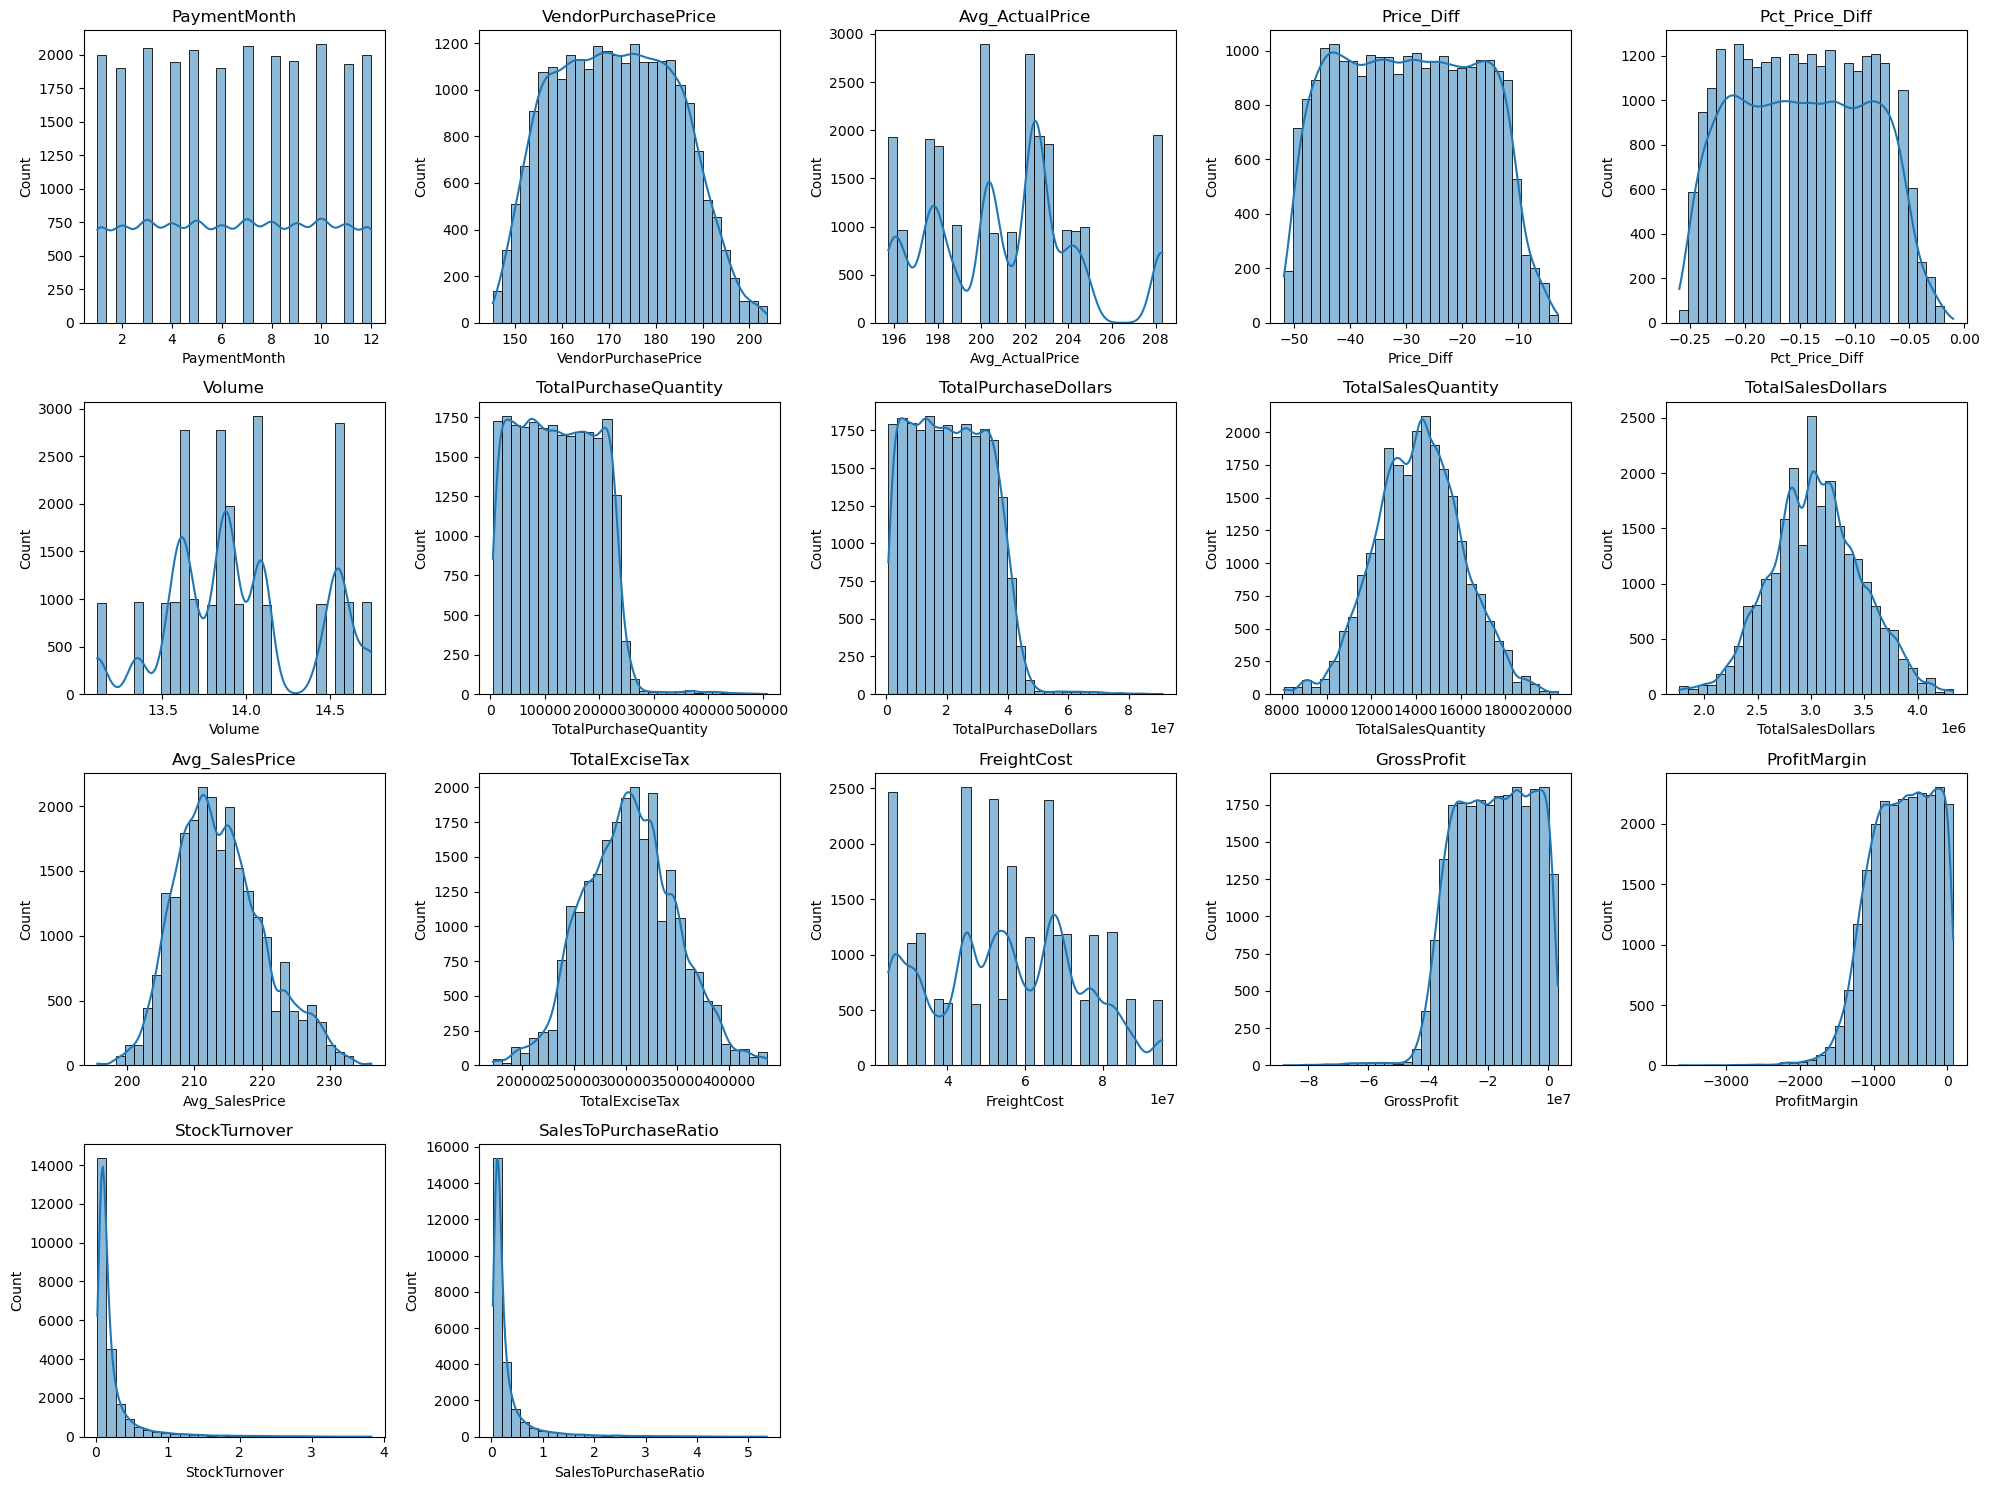

In [21]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols):
    plt.subplot(4,5, i+1)  # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# Observations

1. Wide spread of the VendorPurchasePrice and Price_Diff shows that some vendors are getting better/ worse deals than the others - there's **lack of standardization in the discounts provided**
2. GrossProfit and ProfitMargin, while negative as discussed above, also show extreme outliers - suggesting that **some vendors are extremely unprofitable** as compared to the others (could be due to product-market fit or discount leakages)
3. Purchase (Quantity and Dollars) are left-skewed and extremely large (USD on a scale of crores) while Sales (Quantity and Dollars) are normally distributed (with USD on a scale of lakhs) indicating **misalignment between procurement and sales**:
   - Most vendors purchase smaller quantities but few vendors top the chart with high procurement values (this could be due to over-optimization for discounts i.e. buying more to get better discounts and not as per actual sales demand
   - Sales performance across vendors is uniform. No extreme spikes → no heavy dependence on single vendors for sales. But this also means that even the top vendors (procurement wise) are not generating proportionate sales

_**What can be done?**_
- Introduce demand-based procurement instead of discount-based procurement.
- Adjust discount tiers based on actual sales velocity, not bulk-buying ability.

**Identifying slow-moving brands**

In [22]:
wb = df.groupby('Brand_clean').agg({'StockTurnover': 'mean', 'SalesToPurchaseRatio' : 'mean'}).reset_index()
print("\n---Slow Moving Brands---\n")
wb.sort_values(['StockTurnover','SalesToPurchaseRatio'], ascending = [True, True]).head(5)


---Slow Moving Brands---



,Brand_clean,StockTurnover,SalesToPurchaseRatio
17,Brand_25,0.207205,0.261897
1,Brand_10,0.222943,0.279904
2,Brand_11,0.224878,0.284664
15,Brand_23,0.225118,0.281574
8,Brand_17,0.226046,0.285464


In [23]:
print("\n---Relatively Faster Moving Brands---\n")
wb.sort_values(['StockTurnover','SalesToPurchaseRatio'], ascending = [False, False]).head(5)


---Relatively Faster Moving Brands---



,Brand_clean,StockTurnover,SalesToPurchaseRatio
5,Brand_14,0.280486,0.353422
16,Brand_24,0.261870,0.332571
12,Brand_20,0.259243,0.327501
18,Brand_3,0.257848,0.323115
20,Brand_5,0.255940,0.322435


**What does the demand of these slow-moving brands look like? Are these also highly purchased across vendors?**

In [24]:
pur_sales = pd.read_sql_query("""SELECT 
    pp.*,
    s.SalesQuantity,
    s.SalesDollars,
    s.SalesPrice,
    s.Brand_clean AS Sales_Brand 
    FROM purchase_prices pp JOIN sales s ON pp.VendorNumber = s.VendorNo AND pp.Brand_clean = s.Brand_clean""", engine)

In [25]:
# Aggregating the number of times a brand has been purchases + the revenue it has generated - for EACH vendor
wb = pur_sales.groupby(['VendorNumber','Brand_clean']).agg(purchase_frequency = ('Brand_clean','count'), total_purchase_dollars = ('PurchasePrice','sum')).reset_index()

# Pulling the top brands based on purchase_frequency + revenue_generated - for EACH vendor -- APPROACH 2
wb['score'] = (wb['purchase_frequency'].rank(method='dense', ascending=False) + wb['total_purchase_dollars'].rank(method='dense', ascending=False))
idx = wb.groupby('VendorNumber')['score'].idxmin()  # idxmin() because lower rank number = better
top_by_both = wb.loc[idx].reset_index(drop=True)

# Pulling the top brands based on purchase_frequency + revenue_generated - for EACH vendor -- APPROACH 1
top_purch_brands = wb.sort_values(['purchase_frequency','total_purchase_dollars'], ascending = [False, False]).groupby('VendorNumber').head(1).sort_values('VendorNumber')
top_purch_brands

,VendorNumber,Brand_clean,purchase_frequency,total_purchase_dollars,score
18,V001,Brand_3,1330,269428.60,86.0
28,V002,Brand_12,1700,352930.20,6.0
50,V003,Brand_1,1691,351160.18,8.0
93,V004,Brand_3,1215,213218.73,243.0
105,V005,Brand_14,1886,345238.04,6.0
137,V006,Brand_20,1260,245869.68,129.0
167,V007,Brand_25,1672,301089.96,18.0
185,V008,Brand_19,1328,256849.31,99.0
214,V009,Brand_22,1380,235833.72,130.0
233,V010,Brand_17,1444,280304.72,59.0


In [26]:
top_purch_brands.groupby('Brand_clean')['VendorNumber'].count().reset_index().sort_values('VendorNumber',ascending = False)

,Brand_clean,VendorNumber
6,Brand_17,6
12,Brand_22,4
3,Brand_13,3
16,Brand_3,3
13,Brand_23,3
14,Brand_24,2
2,Brand_12,2
17,Brand_4,2
9,Brand_2,2
1,Brand_10,2


**Count Plots**

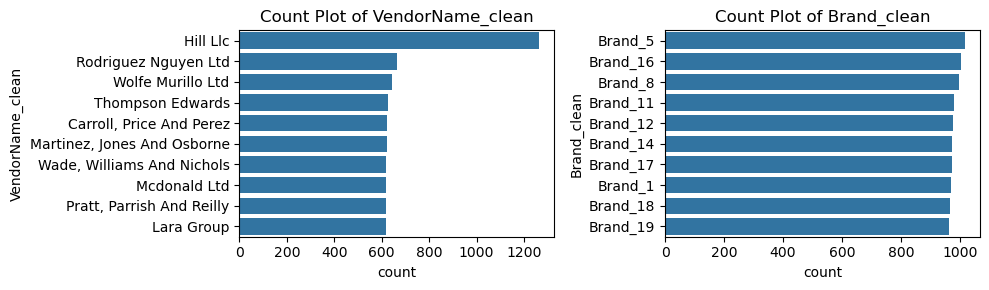

In [27]:
# Count Plots for Categorical Columns
categorical_cols = ["VendorName_clean", "Brand_clean"]

plt.figure(figsize=(10, 3))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])  # Top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

**Correlation Matrix**

In [28]:
correlation_matrix = df[numeric_cols].corr()
correlation_matrix 

,PaymentMonth,VendorPurchasePrice,Avg_ActualPrice,Price_Diff,Pct_Price_Diff,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,Avg_SalesPrice,TotalExciseTax,FreightCost,GrossProfit,ProfitMargin,StockTurnover,SalesToPurchaseRatio
PaymentMonth,1.000000,-0.006192,0.000689,-0.006784,-0.006561,-0.007557,-0.001685,-0.002040,-0.001022,-0.002390,-0.007513,-0.001689,0.000387,0.001957,0.001152,0.000889,0.001049
VendorPurchasePrice,-0.006192,1.000000,0.353135,0.964538,0.973125,0.128756,-0.007151,0.117659,-0.019117,0.056970,0.347568,0.053264,0.002257,-0.115661,-0.101263,0.001329,-0.039796
Avg_ActualPrice,0.000689,0.353135,1.000000,0.093672,0.133753,0.436526,-0.018047,0.023836,-0.022686,0.157491,0.816137,0.152680,0.001476,-0.018409,0.011673,0.002696,0.001884
Price_Diff,-0.006784,0.964538,0.093672,1.000000,0.997831,0.013864,-0.002518,0.118484,-0.013943,0.016194,0.139619,0.013608,0.001986,-0.117889,-0.111054,0.000654,-0.042881
Pct_Price_Diff,-0.006561,0.973125,0.133753,0.997831,1.000000,0.030708,-0.002835,0.119153,-0.014906,0.022327,0.171614,0.019450,0.001408,-0.118347,-0.110383,0.000291,-0.043002
Volume,-0.007557,0.128756,0.436526,0.013864,0.030708,1.000000,0.000358,0.014804,0.030146,0.094939,0.292749,0.087905,0.001531,-0.011532,0.007667,0.006411,0.004958
TotalPurchaseQuantity,-0.001685,-0.007151,-0.018047,-0.002518,-0.002835,0.000358,1.000000,0.989473,0.003811,0.001305,-0.012750,0.000209,-0.007947,-0.989124,-0.952068,-0.596243,-0.593826
TotalPurchaseDollars,-0.002040,0.117659,0.023836,0.118484,0.119153,0.014804,0.989473,1.000000,0.001519,0.008043,0.028493,0.006582,-0.007267,-0.999408,-0.960110,-0.590758,-0.591023
TotalSalesQuantity,-0.001022,-0.019117,-0.022686,-0.013943,-0.014906,0.030146,0.003811,0.001519,1.000000,0.973820,-0.031401,0.935645,0.000952,0.031995,0.229488,0.093485,0.093249
TotalSalesDollars,-0.002390,0.056970,0.157491,0.016194,0.022327,0.094939,0.001305,0.008043,0.973820,1.000000,0.177345,0.961755,-0.004961,0.026374,0.228719,0.093225,0.093742


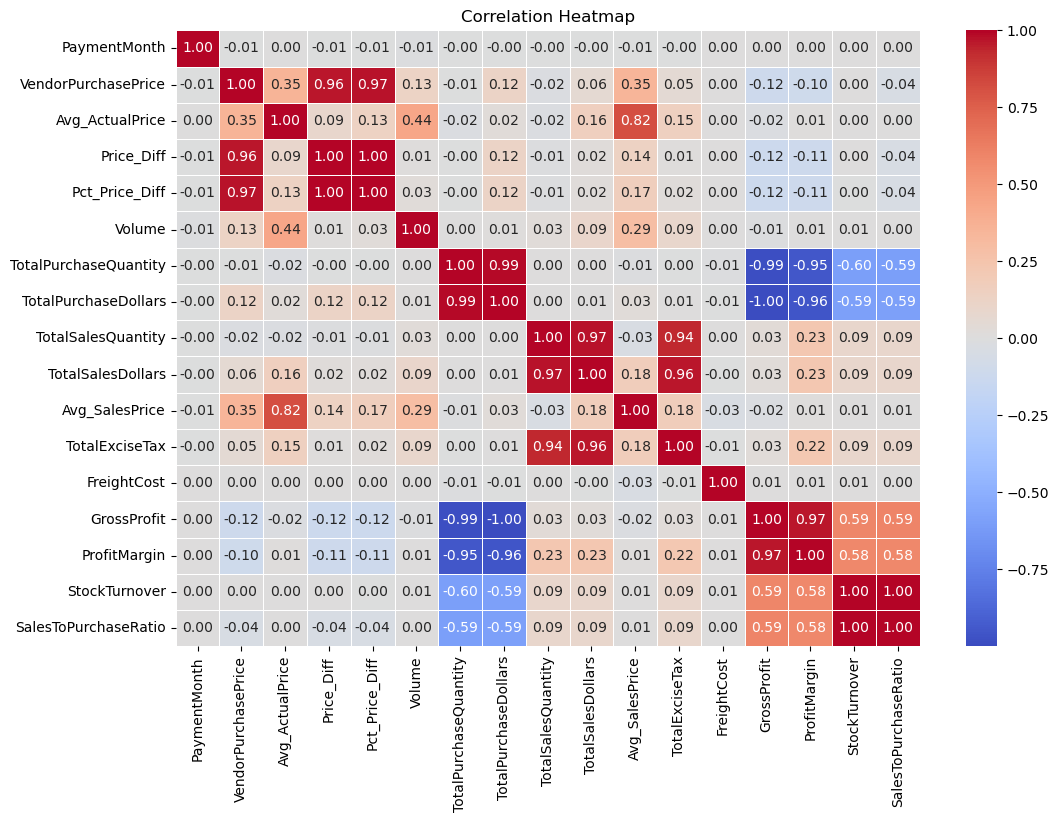

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [30]:
def format_dollars(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{x / 1_000:.2f}K"
    else:
        return str(x)

# **Business Problem Statements**

#### Identify Brands that needs Promotional or Pricing Adjustments which exhibit lower sales performance but higher profit margins.

In [31]:
brand_performance = df.groupby('Description').agg({'TotalSalesDollars':'sum', 'ProfitMargin':'mean'}).reset_index()

In [44]:
# threshold for "low sales" (bottom 15%) and "high margin" (top 15%)
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.85)

# Filter brands with low sales but high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars'] <= low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)]

target_brands['TotalSalesDollars'] = target_brands['TotalSalesDollars'].apply(lambda x: format_dollars(x))

print("Brands with Low Sales but High Profit Margins:")
display(target_brands.sort_values('TotalSalesDollars'))

Brands with Low Sales but High Profit Margins:


,Description,TotalSalesDollars,ProfitMargin
118,Product_43,3.162867e+08,-517.342551
66,Product_159,3.440572e+08,-544.387236
18,Product_115,3.472618e+08,-547.099270
54,Product_148,3.560300e+08,-564.957003
88,Product_179,3.650556e+08,-553.838633


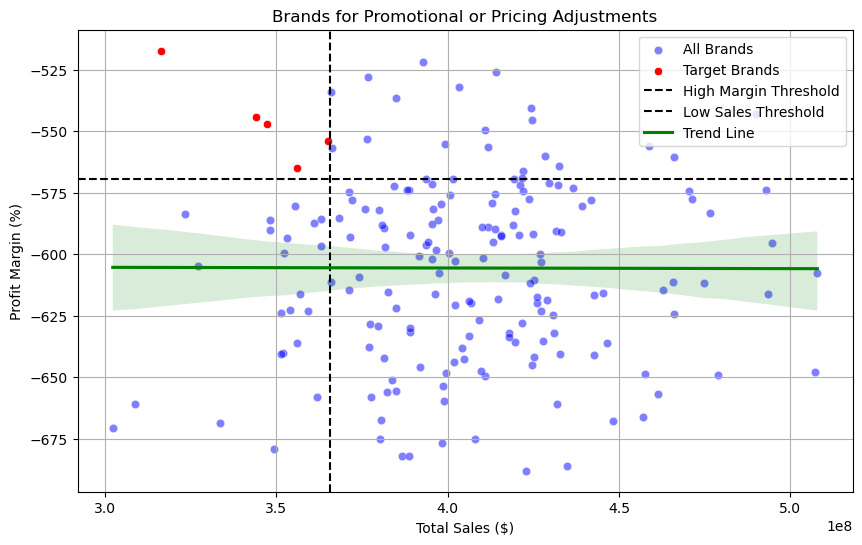

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', color="blue", label="All Brands", alpha = 0.5)
sns.scatterplot(data=target_brands, x='TotalSalesDollars', y='ProfitMargin', color="red", label="Target Brands")

plt.axhline(high_margin_threshold, linestyle='--', color='black', label="High Margin Threshold")
plt.axvline(low_sales_threshold, linestyle='--', color='black', label="Low Sales Threshold")

# Add the best-fit / trend line here
sns.regplot(data=brand_performance, x='TotalSalesDollars', y='ProfitMargin', 
            scatter=False, color="green", label="Trend Line")

plt.xlabel("Total Sales ($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotional or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

#### Which vendors and brands demonstrate the highest sales performance?

In [34]:
# Top Vendors & Brands by Sales Performance
top_vendors = df.groupby("VendorName_clean")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)
top_vendors

VendorName_clean
Hill Llc                     3.919183e+09
Rodriguez Nguyen Ltd         2.022065e+09
Grant Adams Ltd              1.943639e+09
Pratt, Parrish And Reilly    1.911295e+09
Harris Plc                   1.907033e+09
Lara Group                   1.890535e+09
Carroll, Price And Perez     1.886193e+09
Norris Ortega                1.879875e+09
Gaines Mckinney Ltd          1.876535e+09
Mcdonald Ltd                 1.871396e+09
Name: TotalSalesDollars, dtype: float64

In [35]:
top_vendors.apply(lambda x: format_dollars(x))

VendorName_clean
Hill Llc                     3919.18M
Rodriguez Nguyen Ltd         2022.06M
Grant Adams Ltd              1943.64M
Pratt, Parrish And Reilly    1911.30M
Harris Plc                   1907.03M
Lara Group                   1890.54M
Carroll, Price And Perez     1886.19M
Norris Ortega                1879.88M
Gaines Mckinney Ltd          1876.54M
Mcdonald Ltd                 1871.40M
Name: TotalSalesDollars, dtype: object

In [36]:
top_brands.apply(lambda x: format_dollars(x))

Description
Product_175    507.93M
Product_96     507.27M
Product_88     494.75M
Product_51     493.52M
Product_111    492.88M
Product_116    490.14M
Product_99     478.88M
Product_143    476.66M
Product_168    474.88M
Product_128    471.35M
Name: TotalSalesDollars, dtype: object

C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\2557152966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\2557152966.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")


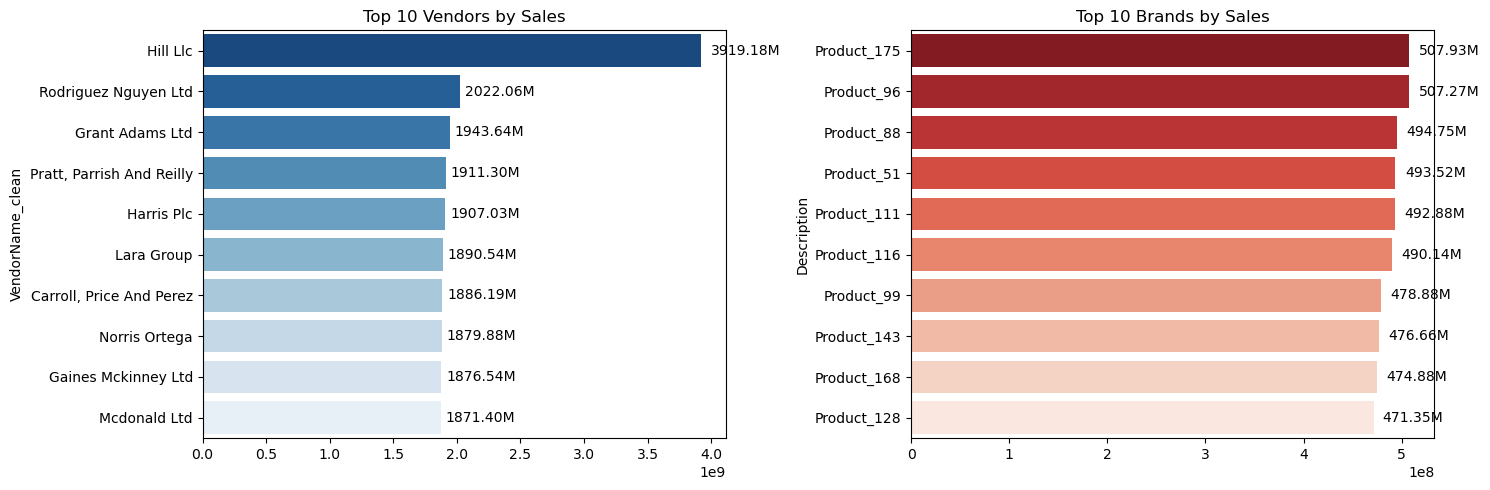

In [37]:
plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette="Blues_r")
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02), 
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), 
             ha='left', va='center', fontsize=10, color='black')

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_brands.index.astype(str), x=top_brands.values, palette="Reds_r")
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02), 
             bar.get_y() + bar.get_height() / 2, 
             format_dollars(bar.get_width()), 
             ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Which vendors contribute the most to total purchase dollars?

In [38]:
vendor_performance = df.groupby('VendorName_clean')['TotalPurchaseDollars'].sum().reset_index().sort_values('TotalPurchaseDollars',ascending = False)

# Calculate % contribution
vendor_performance["Purchase_Contribution%"] = (vendor_performance["TotalPurchaseDollars"] / vendor_performance["TotalPurchaseDollars"].sum()) * 100

# Rank Vendors by Total Purchase Dollars 
vendor_performance = round(vendor_performance.sort_values(by="TotalPurchaseDollars", ascending=False),2)

# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
print(f"Total Purchase Contribution of top 10 vendors is {round(top_vendors['Purchase_Contribution%'].sum(),2)} %")
display(top_vendors)

Total Purchase Contribution of top 10 vendors is 29.35 %


,VendorName_clean,TotalPurchaseDollars,Purchase_Contribution%
13,Hill Llc,2.663487e+10,5.29
29,Rodriguez Nguyen Ltd,1.374462e+10,2.73
33,Thompson Edwards,1.374008e+10,2.73
3,"Carroll, Price And Perez",1.361004e+10,2.70
18,Lara Group,1.360579e+10,2.70
38,Wolfe Murillo Ltd,1.349901e+10,2.68
35,"Wade, Williams And Nichols",1.340580e+10,2.66
11,Harris Plc,1.322738e+10,2.63
15,"Johnson, Carey And Nichols",1.317776e+10,2.62
19,Long Roberts,1.316384e+10,2.61


In [39]:
format_dollars(top_vendors['TotalPurchaseDollars'].sum())

'147809.18M'

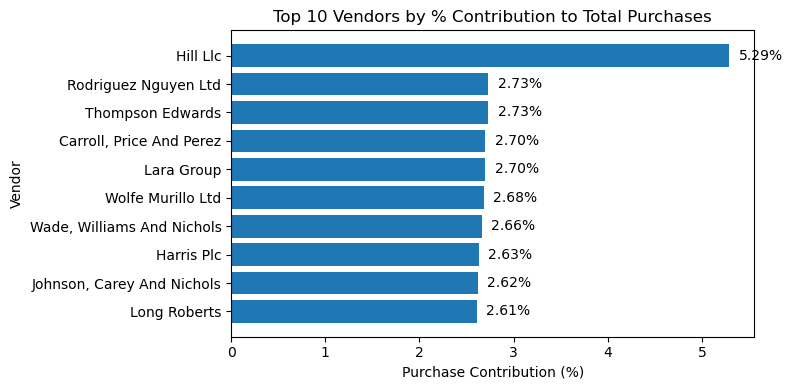

In [40]:
plt.figure(figsize=(8, 4))
plt.barh(
    top_vendors['VendorName_clean'],
    top_vendors['Purchase_Contribution%']
)

# Invert y-axis so highest appears on top
plt.gca().invert_yaxis()

# Labels & Title
plt.xlabel("Purchase Contribution (%)")
plt.ylabel("Vendor")
plt.title("Top 10 Vendors by % Contribution to Total Purchases")

# Add values inside bars
for index, value in enumerate(top_vendors['Purchase_Contribution%']):
    plt.text(value + 0.1, index, f"{value:.2f}%", va='center')

plt.tight_layout()
plt.show()

#### Which vendors contribute the most to total sales dollars?

In [47]:
vendor_performance = df.groupby('VendorName_clean')['TotalSalesDollars'].sum().reset_index().sort_values('TotalSalesDollars',ascending = False)

# Calculate % contribution
vendor_performance["Sales_Contribution%"] = (vendor_performance["TotalSalesDollars"] / vendor_performance["TotalSalesDollars"].sum()) * 100

# Rank Vendors by Total Sales Dollars 
vendor_performance = round(vendor_performance.sort_values(by="TotalSalesDollars", ascending=False),2)

# Display Top 10 Vendors
top_vendors = vendor_performance.head(10)
print(f"Total Sales Contribution of top 10 vendors is {round(top_vendors['Sales_Contribution%'].sum(),2)} %")
display(top_vendors)

Total Sales Contribution of top 10 vendors is 29.0 %


,VendorName_clean,TotalSalesDollars,Sales_Contribution%
13,Hill Llc,3.919183e+09,5.38
29,Rodriguez Nguyen Ltd,2.022065e+09,2.78
8,Grant Adams Ltd,1.943639e+09,2.67
27,"Pratt, Parrish And Reilly",1.911295e+09,2.63
11,Harris Plc,1.907033e+09,2.62
18,Lara Group,1.890535e+09,2.60
3,"Carroll, Price And Perez",1.886193e+09,2.59
25,Norris Ortega,1.879875e+09,2.58
7,Gaines Mckinney Ltd,1.876535e+09,2.58
23,Mcdonald Ltd,1.871396e+09,2.57


#### Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [41]:
# Calculate Unit Purchase Price per Vendor 
df["UnitPurchasePrice"] = df["TotalPurchaseDollars"] / df["TotalPurchaseQuantity"]

# Calculate average total_quantity and unit_price for each vendor-product group as the quantity ordered may differ "per vendor"
prod_summary = df.groupby(['Description','VendorName_clean']).agg({'TotalPurchaseQuantity': 'mean', 'UnitPurchasePrice': 'mean'}).reset_index(names=['Product','Vendor'])

# Add Order Sizes (e.g., Small, Medium, Large Purchases) WITHOUT GROUPING as the reference scale of Order Size should be consistent globally. Group by Vendor and Product when vendor-level insights are needed
prod_summary["OrderSize"] = pd.qcut(prod_summary['TotalPurchaseQuantity'], q=3, labels=["Small", "Medium", "Large"])
prod_summary

# Group by Order Sizes per Product as we need to analyse product wise optimal volume
prod_bulk_purchase_analysis = prod_summary.groupby(['Product','OrderSize'])["UnitPurchasePrice"].mean().reset_index()
prod_bulk_purchase_analysis

bulk_purchase_analysis = prod_summary.groupby('OrderSize')["UnitPurchasePrice"].mean().reset_index()
bulk_purchase_analysis 

C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\2013106806.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prod_bulk_purchase_analysis = prod_summary.groupby(['Product','OrderSize'])["UnitPurchasePrice"].mean().reset_index()
C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\2013106806.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bulk_purchase_analysis = prod_summary.groupby('OrderSize')["UnitPurchasePrice"].mean().reset_index()


,OrderSize,UnitPurchasePrice
0,Small,171.910675
1,Medium,171.464257
2,Large,171.522707


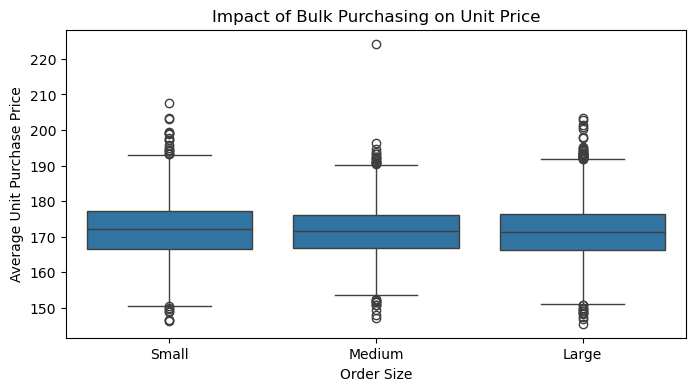

In [42]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=prod_summary, x="OrderSize", y="UnitPurchasePrice")
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

In [43]:
prod_summary.groupby('OrderSize').agg(min = ('TotalPurchaseQuantity','min'), max = ('TotalPurchaseQuantity', 'max'))

C:\Users\nisha\AppData\Local\Temp\ipykernel_11640\192111064.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prod_summary.groupby('OrderSize').agg(min = ('TotalPurchaseQuantity','min'), max = ('TotalPurchaseQuantity', 'max'))


,min,max
OrderSize,,
Small,4790.000000,104910.50
Medium,104916.666667,140060.25
Large,140077.750000,428220.00


# Key Insights

**Question 1:**
No correlation between Sales and Margins indicate: 
- Selling more doesn't get better margin or worse margin
- High-volume vendors aren’t getting better margins OR not using margin to sell more
  
**Question 2:**
Top 10 vendors contribute only ~29% of total purchases — the largest vendor accounts for just ~5%. The remaining vendors contribute <= 2% each
- We don’t have anchor/strategic buyers driving volume consistency
- Revenue model depends on many small vendors

**Question 3:**
Unit purchase price remains ~170 across Small, Medium, and Large order sizes, meaning vendors get no meaningful economic benefit from ordering more